## Nano GPT

In this notebook I will be building a ~11M parameter 6-layer Transformer based character level decoder model which will endlessely produce questions, the prize for that question and answer to the question based on the popular game 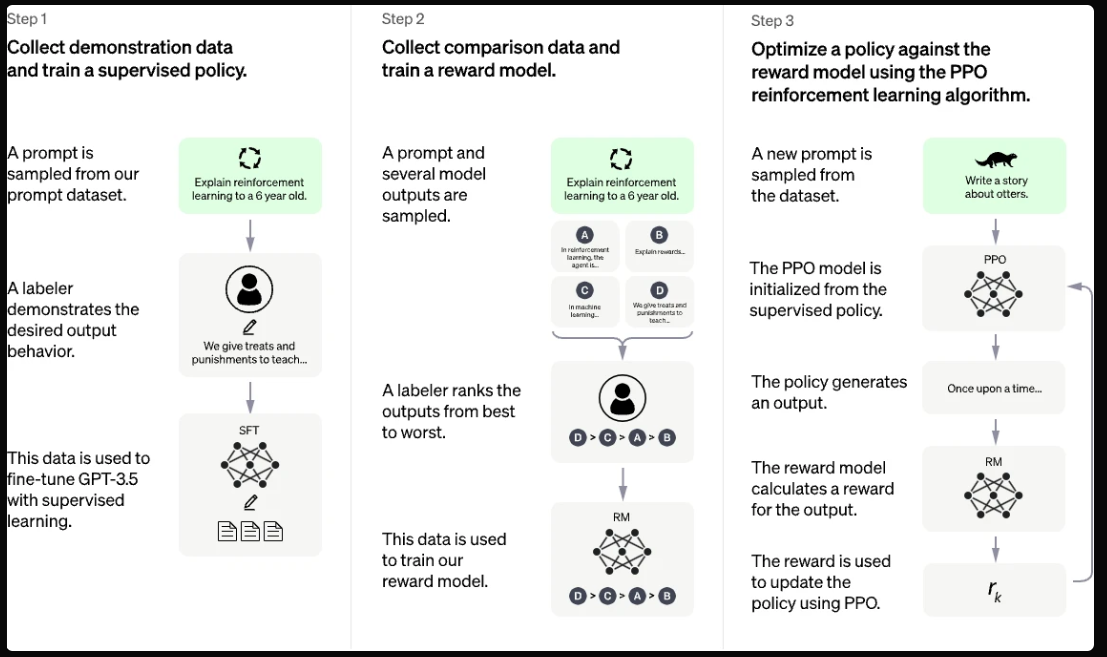show 'Jeopardy'. This notebook is a direct implementation of Andrej Karpathy's '[Let's Build GPT](https://www.youtube.com/watch?v=kCc8FmEb1nY&t=481s)' video.

I have the dataset on my drive because it will be faster to load the data from a drive insteading of waiting to upload the file on colab's file managment.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


The data also has additional values such as category, air_date, round and show_number which we won't be using. We will only be making the transformer generate the question, value and the answer fields.

In [2]:
import json

with open('/content/drive/MyDrive/Train Data/JEOPARDY_QUESTIONS1.json', 'r') as file:
    data = json.load(file)

formatted_output = ""

for entry in data:
    formatted_output += f"Question:\n{entry['question']}\n\n"
    formatted_output += f"Value:\n{entry['value']}\n\n"
    formatted_output += f"Answer:\n{entry['answer']}\n\n"


Printing the length of the training data, we can see that it roughly consists of 29 million characters.

In [3]:
len(formatted_output)

29375540

Setting the hyper parameters to train and evaluate the model.

In [5]:
import torch
import torch.nn as nn
from torch.nn import functional as F

# hyperparameters
batch_size = 64 # how many independent sequences will we process in parallel?
block_size = 256 # what is the maximum context length for predictions?
max_iters = 3300
eval_interval = 300
learning_rate = 2e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 384
n_head = 6
n_layer = 6
dropout = 0.2
# ------------

torch.manual_seed(1453)                           # Setting a random seed



Initialising the vocabulary size and a simple encoder decoder which maps every character in the vocabulary to an integer and vice versa.

In [6]:
chars = sorted(list(set(formatted_output)))
vocab_size = len(chars)
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l])

Printing the unique characters will get you all the possible characters that can be generated by the model.

In [9]:
print(''.join(chars))


 !"#$%&'()*+,-./0123456789:;<=>?@ABCDEFGHIJKLMNOPQRSTUVWXYZ[\]^_`abcdefghijklmnopqrstuvwxyz{|}¡¢£°²·º¼½¾¿ÁÅÉÎÖ×àáâãäåæçèéêëìíîïñòóôö÷øúûüăćČęłōœřšế–—‘’“”•…


And this will the vocabulary size of the model:

In [8]:
vocab_size

156

In [ ]:
data = torch.tensor(encode(formatted_output), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

Splitting 90% of the data for training and the remaining 10% validation will give us the following counts

In [ ]:
len(train_data), len(val_data)

(26437986, 2937554)

A function to generate inputs and outputs

In [ ]:
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

A function to calculate the training and validation loss.

In [ ]:
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

Defining a single class of attention which passes the inputs into key, query and value vectors and generates weights that will only contain the present and the previous tokens by using an attention mask.

In [ ]:
class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # input of size (batch, time-step, channels)
        # output of size (batch, time-step, head size)
        B,T,C = x.shape
        k = self.key(x)
        q = self.query(x)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * k.shape[-1]**-0.5 # (B, T, hs) @ (B, hs, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x)
        out = wei @ v # (B, T, T) @ (B, T, hs) -> (B, T, hs)
        return out

Another class that iterates num_heads times over the previous class, producing a transformer with num_heads (6 in this case) heads, each with head_size (also 6 in this case) units in parallel.

In [ ]:
class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(head_size * num_heads, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

A feedforward layer with a linear transformation, a ReLU non-linearity, and a dropout layer.

In [ ]:
class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

A transformer block consisting of multi-head self-attention and feedforward layers, each followed by layer normalization

In [ ]:
class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

A class to define the full model with token an dpositional embeddings, n_layer(6) attention blocks each containing multi-head self-attention with 6 heads. A linear layer to predict the new tokens.

In [ ]:
class GPTLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss
    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -block_size:]
            logits, loss = self(idx_cond)
            logits = logits[:, -1, :] # becomes (B, C)
            probs = F.softmax(logits, dim=-1) # (B, C)
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

Initialising the model and pushing the model onto the GPU

In [ ]:
model = GPTLanguageModel()
m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

10.858908 M parameters


Initialisin the optimiser

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

Training the model on colab's l4 gpu for 3300 iterations. This training took ~25-30 mins.

In [ ]:
for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

step 0: train loss 5.1104, val loss 5.1102
step 300: train loss 1.8194, val loss 1.8220
step 600: train loss 1.5397, val loss 1.5397
step 900: train loss 1.4003, val loss 1.4002
step 1200: train loss 1.3066, val loss 1.3105
step 1500: train loss 1.2438, val loss 1.2494
step 1800: train loss 1.2008, val loss 1.2036
step 2100: train loss 1.1608, val loss 1.1680
step 2400: train loss 1.1434, val loss 1.1456
step 2700: train loss 1.1149, val loss 1.1245
step 3000: train loss 1.1003, val loss 1.1069
step 3299: train loss 1.0823, val loss 1.0879


Saving the model to drive

In [ ]:
save_path = r'/content/drive/MyDrive/Trained-GPT2/gpt_jeopardy_language_model.pth'

torch.save(model.state_dict(), save_path)
print(f"Model saved to {save_path}")

Model saved to /content/drive/MyDrive/Trained-GPT2/gpt_jeopardy_language_model.pth


Loading the model from drive.

In [ ]:
# Define the save path, ensuring it's correctly formatted
save_path = r'/content/drive/MyDrive/Trained-GPT2/gpt_jeopardy_language_model.pth'

# Create a new instance of the model
model = GPTLanguageModel()
model = model.to(device)

# Load the saved state dictionary
model.load_state_dict(torch.load(save_path))
print("Model loaded successfully")


Model loaded successfully


Generating 500 new tokens(characters) using a 1x1 '0' tensor as an initial context.

In [ ]:
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(model.generate(context, max_new_tokens=500)[0].tolist()))


Verittes

Question:
'Aso-ceremosorts, this malihasterconoman often & sound severals & concremetes the Grandfire'

Value:
$100

Answer:
Jule Luthana

Question:
'One of the having game, took making the presidents giving, what harushed & they'll be had kids'

Value:
$100

Answer:
"Tale Omastar\'s

Question:
'The only refuncal stry per No. 7, the UHO BM town estilland'

Value:
$200

Answer:
Moongo (Egyppe arol) (other Rosever)

Question:
'Criper Freying astample tells you we're itempired was commert


Generating another 500 tokens with a random token as the initial context.

In [ ]:
context_length = 1
context = torch.randint(0, vocab_size, (1, context_length), dtype=torch.long, device=device)
generated_tokens = model.generate(context, max_new_tokens=500)[0].tolist()
print(decode(generated_tokens))


49,940 C.Y.; with this country was much him from the Summuter Fride'

Value:
$600

Answer:
Walkenz Hiler

Question:
'This name, TV Gates careen writte Vaitic eans with a restory subject'

Value:
$600

Answer:
Trenstone Juiuser

Question:
'Museum has as Italian for one is buried pressings carvetes from the "megabring" in these births impress'

Value:
$800

Answer:
methings

Question:
'Mixerings the originist with a lamousy emperor'

Value:
$600

Answer:
a feepus

Question:
'May 1 6/2 works around 


Generating 5000 new tokens again with a random token as the initial context.

In [ ]:
context = torch.randint(0, vocab_size, (1, context_length), dtype=torch.long, device=device)
print(decode(model.generate(context, max_new_tokens=5000)[0].tolist()))

99 Control Dat

Question:
'"A English Art" may have directive this 19th century that empired with money dimes on to Archio Bunkespan'

Value:
$1600

Answer:
March and Day

Question:
'MDA Hearters are & savestraits advieIsle & Turkes included this Isle Coup</a> re-rhanization'

Value:
$1600

Answer:
O

Question:
'This seah beings one on the since that the hutrium to sand "Faranis War Morganis Church to the world"'

Value:
$1600

Answer:
Jis Faverenton doctor

Question:
'In 1960 the Gemisilee alement classic stave that n pop students rowged by starts for watchilded from the spreword cates'

Value:
$1000

Answer:
Higaran

Question:
'Known as this F'stantmal waspected patrements & wrearch fit'

Value:
$1000

Answer:
igisivs

Question:
'Senaturing maprically by ones 3 small, & data croops & 8000'

Value:
$200

Answer:
Earther Royal Authon Corgum

Question:
'We north featured to this Red-Stoner leage was after the sygolzaling name'

Value:
$1000

Answer:
Brady Lucisman

Question:
'On Aug. 81

From the output we can see that the transformer is maintaining the structure of the training data and the output somewhat looks like rounds of jeopardy. The output words don't make sense because we're doing a very basic character level tokenising. Changing the tokeniser to a better tokeniser will drastically improve the quality but it would still not be the gpt chatbot that we all know.

To get this model to behave like a chatbot that can answer any generic user questions, firstly the model will have to be trained on trillions and trillions of tokens(the model in the notebook is only trained on ~30 million tokens) and alignment of the model has to be done and alignment is a very tedious and very very expensive task that only huge companies like openai, google and microsoft can afford. I will post a photo describing the high level steps of allignment that openAI had to do for gpt-3 to behave like a chatbot.

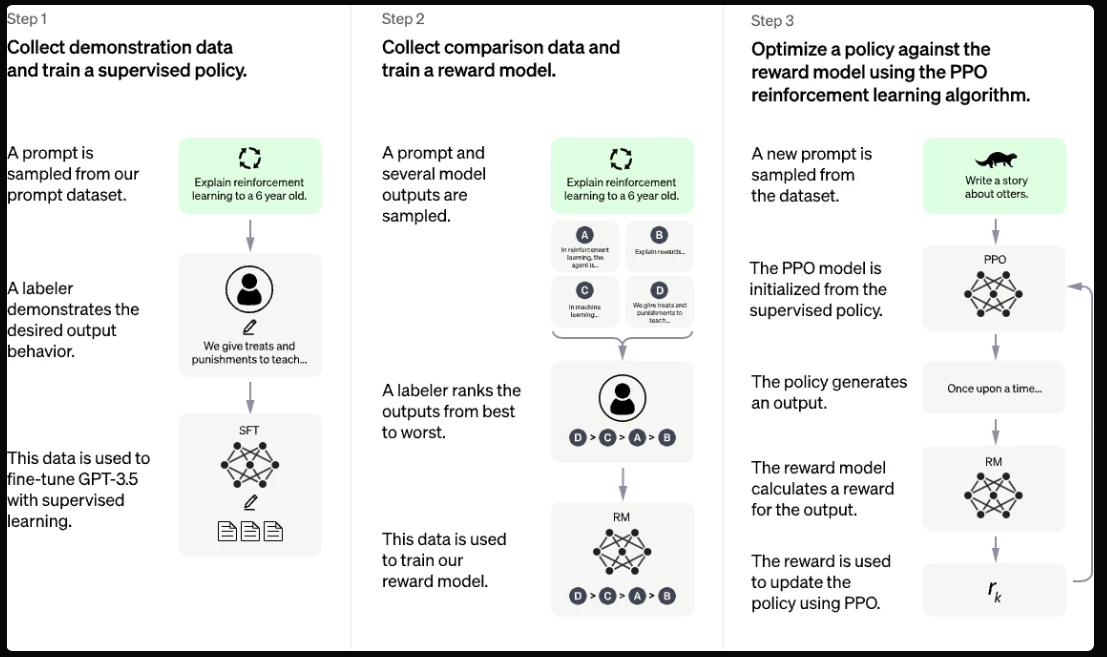

source: https://openai.com/index/chatgpt/

From the image above it is clear that it's impossible to get the model aligned and I cannot do it alone. So I will be focussing on implementing a better tokeniser for the model and will post that model as soon as it's ready on my github.